## summary

* 2.5d segmentation
    *  segmentation_models_pytorch 
    *  Unet
* use only 6 slices in the middle
* slide inference

In [1]:
# !pip install -q ../input/pytorch-segmentation-models-lib/pretrainedmodels-0.7.4/pretrainedmodels-0.7.4
# !pip install -q ../input/pytorch-segmentation-models-lib/efficientnet_pytorch-0.6.3/efficientnet_pytorch-0.6.3
# !pip install -q ../input/pytorch-segmentation-models-lib/timm-0.4.12-py3-none-any.whl
# !pip install -q ../input/pytorch-segmentation-models-lib/segmentation_models_pytorch-0.2.0-py3-none-any.whl

In [2]:
# !mkdir -p /root/.cache/torch/hub/checkpoints/
# !cp ../input/efficientnet-b0-355c32eb.pth /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth

In [3]:
# !pip install torch==1.10.2+cu113 torchvision==0.11.3+cu113 torchaudio===0.10.2+cu113 -f https://download.pytorch.org/whl/cu113/torch_stable.html

In [4]:

from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, log_loss
import pickle
from torch.utils.data import DataLoader
from torch.cuda.amp import autocast, GradScaler
import warnings
import sys
import pandas as pd
import os
import gc
import sys
import math
import time
import random
import shutil
from pathlib import Path
from contextlib import contextmanager
from collections import defaultdict, Counter
import cv2

import scipy as sp
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from functools import partial

import argparse
import importlib
import torch
import torch.nn as nn
from torch.optim import Adam, SGD, AdamW

import datetime

In [5]:
# sys.path.append('/kaggle/input/pretrainedmodels/pretrainedmodels-0.7.4')
# sys.path.append('/kaggle/input/efficientnet-pytorch/EfficientNet-PyTorch-master')
# sys.path.append('/kaggle/input/timm-pytorch-image-models/pytorch-image-models-master')
# sys.path.append('/kaggle/input/segmentation-models-pytorch/segmentation_models.pytorch-master')

In [6]:
import segmentation_models_pytorch as smp

In [7]:
import numpy as np
from torch.utils.data import DataLoader, Dataset
import cv2
import torch
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

## config

In [8]:
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2

class CFG:
    # ============== comp exp name =============
    comp_name = 'vesuvius'

    # comp_dir_path = './'
    comp_dir_path = '../input/'
    comp_folder_name = 'vesuvius-challenge-ink-detection'
    # comp_dataset_path = f'{comp_dir_path}datasets/{comp_folder_name}/'
    comp_dataset_path = f'{comp_dir_path}{comp_folder_name}/'
    
    exp_name = 'resnet-exp009'#'vesuvius_2d_slide_exp002'

    # ============== pred target =============
    target_size = 1

    # ============== model cfg =============
    model_name = 'Unet'
    # backbone = 'efficientnet-b0'
    # backbone = 'se_resnext50_32x4d'
    backbone = 'se_resnext101_32x4d'

    in_chans = 6 # 65
    # ============== training cfg =============
    size = 224
    tile_size = 224
    stride = tile_size // 2

    train_batch_size = 16 # 32
    valid_batch_size = train_batch_size * 2
    use_amp = True

    scheduler = 'GradualWarmupSchedulerV2'
    # scheduler = 'CosineAnnealingLR'
    epochs = 30 # 15

    # adamW warmupあり
    warmup_factor = 10
    # lr = 1e-4 / warmup_factor
    lr = 1e-4 / warmup_factor

    # ============== fold =============
    valid_id = 1

    # objective_cv = 'binary'  # 'binary', 'multiclass', 'regression'
    metric_direction = 'maximize'  # maximize, 'minimize'
    # metrics = 'dice_coef'

    # ============== fixed =============
    pretrained = True
    inf_weight = 'best'  # 'best'

    min_lr = 1e-6
    weight_decay = 1e-6
    max_grad_norm = 1000

    print_freq = 50
    num_workers = 4

    seed = 42

    # ============== set dataset path =============
    print('set dataset path')

    outputs_path = f'../output/{comp_name}/{exp_name}/'

    submission_dir = outputs_path + 'submissions/'
    submission_path = submission_dir + f'submission_{exp_name}.csv'

    model_dir = outputs_path + \
        f'{comp_name}-models/'

    figures_dir = outputs_path + 'figures/'

    log_dir = outputs_path + 'logs/'
    log_path = log_dir + f'{exp_name}.txt'

    # ============== augmentation =============
    train_aug_list = [
        # A.RandomResizedCrop(
        #     size, size, scale=(0.85, 1.0)),
        A.Resize(size, size),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.75),
        A.ShiftScaleRotate(p=0.75),
        A.OneOf([
                A.GaussNoise(var_limit=[10, 50]),
                A.GaussianBlur(),
                A.MotionBlur(),
                ], p=0.4),
        A.GridDistortion(num_steps=5, distort_limit=0.3, p=0.5),
        A.CoarseDropout(max_holes=1, max_width=int(size * 0.3), max_height=int(size * 0.3), 
                        mask_fill_value=0, p=0.5),
        # A.Cutout(max_h_size=int(size * 0.6),
        #          max_w_size=int(size * 0.6), num_holes=1, p=1.0),
        A.Normalize(
            mean= [0] * in_chans,
            std= [1] * in_chans
        ),
        ToTensorV2(transpose_mask=True),
    ]

    valid_aug_list = [
        A.Resize(size, size),
        A.Normalize(
            mean= [0] * in_chans,
            std= [1] * in_chans
        ),
        ToTensorV2(transpose_mask=True),
    ]


set dataset path


## helper

In [9]:
class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [10]:
def init_logger(log_file):
    from logging import getLogger, INFO, FileHandler, Formatter, StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

def set_seed(seed=None, cudnn_deterministic=True):
    if seed is None:
        seed = 42

    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = cudnn_deterministic
    torch.backends.cudnn.benchmark = False

In [11]:
def make_dirs(cfg):
    for dir in [cfg.model_dir, cfg.figures_dir, cfg.submission_dir, cfg.log_dir]:
        os.makedirs(dir, exist_ok=True)

In [12]:
def cfg_init(cfg, mode='train'):
    set_seed(cfg.seed)
    # set_env_name()
    # set_dataset_path(cfg)

    if mode == 'train':
        make_dirs(cfg)

In [13]:
cfg_init(CFG)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Logger = init_logger(log_file=CFG.log_path)

Logger.info('\n\n-------- exp_info -----------------')
# Logger.info(datetime.datetime.now().strftime('%Y年%m月%d日 %H:%M:%S'))



-------- exp_info -----------------


## image, mask

In [14]:
def read_image_mask(fragment_id):

    images = []

    # idxs = range(65)
    mid = 65 // 3 # mid = 65 // 2
    start = mid - CFG.in_chans // 2
    end = mid + CFG.in_chans // 2
    idxs = range(start, end)

    for i in tqdm(idxs):
        
        image = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/surface_volume/{i:02}.tif", 0)

        pad0 = (CFG.tile_size - image.shape[0] % CFG.tile_size)
        pad1 = (CFG.tile_size - image.shape[1] % CFG.tile_size)

        image = np.pad(image, [(0, pad0), (0, pad1)], constant_values=0)

        images.append(image)
    images = np.stack(images, axis=2)

    mask = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/inklabels.png", 0)
    mask = np.pad(mask, [(0, pad0), (0, pad1)], constant_values=0)

    mask = mask.astype('float32')
    mask /= 255.0
    
    return images, mask

In [15]:
def get_train_valid_dataset():
    train_images = []
    train_masks = []

    valid_images = []
    valid_masks = []
    valid_xyxys = []

    for fragment_id in range(1, 4):

        image, mask = read_image_mask(fragment_id)

        x1_list = list(range(0, image.shape[1]-CFG.tile_size+1, CFG.stride))
        y1_list = list(range(0, image.shape[0]-CFG.tile_size+1, CFG.stride))

        for y1 in y1_list:
            for x1 in x1_list:
                y2 = y1 + CFG.tile_size
                x2 = x1 + CFG.tile_size
                # xyxys.append((x1, y1, x2, y2))
        
                if fragment_id == CFG.valid_id:
                    valid_images.append(image[y1:y2, x1:x2])
                    valid_masks.append(mask[y1:y2, x1:x2, None])

                    valid_xyxys.append([x1, y1, x2, y2])
                else:
                    train_images.append(image[y1:y2, x1:x2])
                    train_masks.append(mask[y1:y2, x1:x2, None])

    return train_images, train_masks, valid_images, valid_masks, valid_xyxys

In [16]:
train_images, train_masks, valid_images, valid_masks, valid_xyxys = get_train_valid_dataset()

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

In [17]:
# valid_xyxys = np.stack(valid_xyxys)

## dataset

In [18]:
import numpy as np
from torch.utils.data import DataLoader, Dataset
import cv2
import torch
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

In [19]:
def get_transforms(data, cfg):
    if data == 'train':
        aug = A.Compose(cfg.train_aug_list)
    elif data == 'valid':
        aug = A.Compose(cfg.valid_aug_list)

    # print(aug)
    return aug

class CustomDataset(Dataset):
    def __init__(self, images, cfg, labels=None, transform=None):
        self.images = images
        self.cfg = cfg
        self.labels = labels
        self.transform = transform

    def __len__(self):
        # return len(self.df)
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            data = self.transform(image=image, mask=label)
            image = data['image']
            label = data['mask']

        return image, label

In [20]:

train_dataset = CustomDataset(
    train_images, CFG, labels=train_masks, transform=get_transforms(data='train', cfg=CFG))
valid_dataset = CustomDataset(
    valid_images, CFG, labels=valid_masks, transform=get_transforms(data='valid', cfg=CFG))

train_loader = DataLoader(train_dataset,
                          batch_size=CFG.train_batch_size,
                          shuffle=True,
                          num_workers=CFG.num_workers, pin_memory=True, drop_last=True,
                          )
valid_loader = DataLoader(valid_dataset,
                          batch_size=CFG.valid_batch_size,
                          shuffle=False,
                          num_workers=CFG.num_workers, pin_memory=True, drop_last=False)


In [21]:
train_dataset[0][0].shape

torch.Size([6, 224, 224])

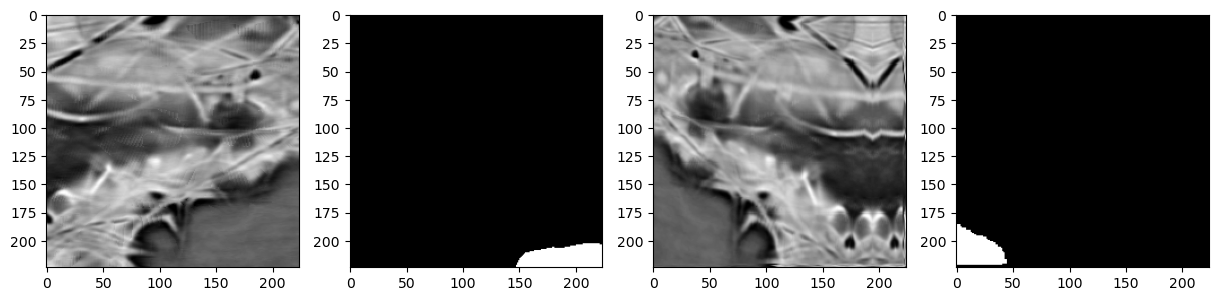

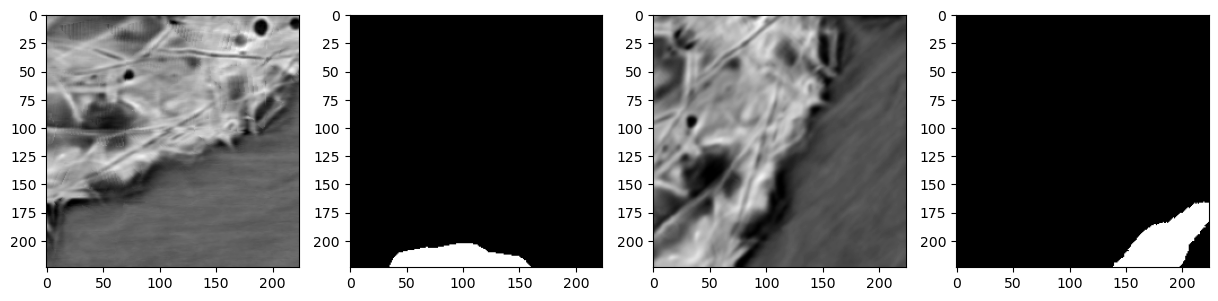

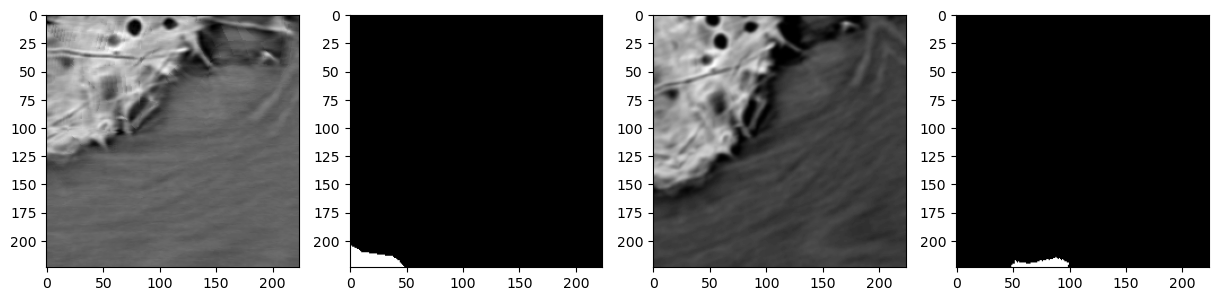

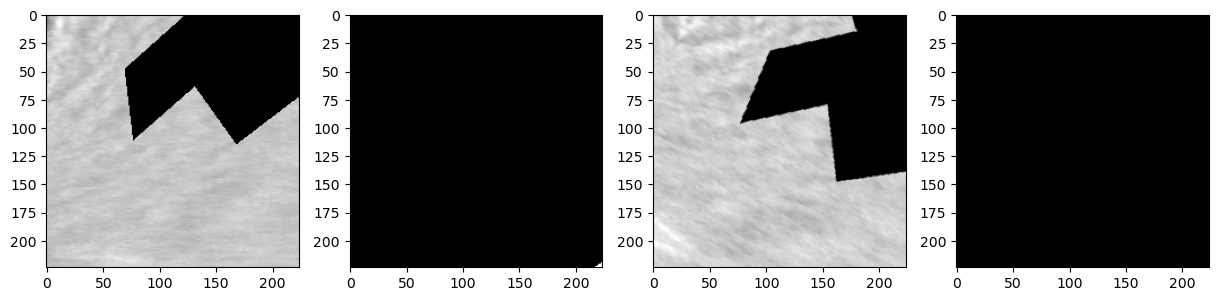

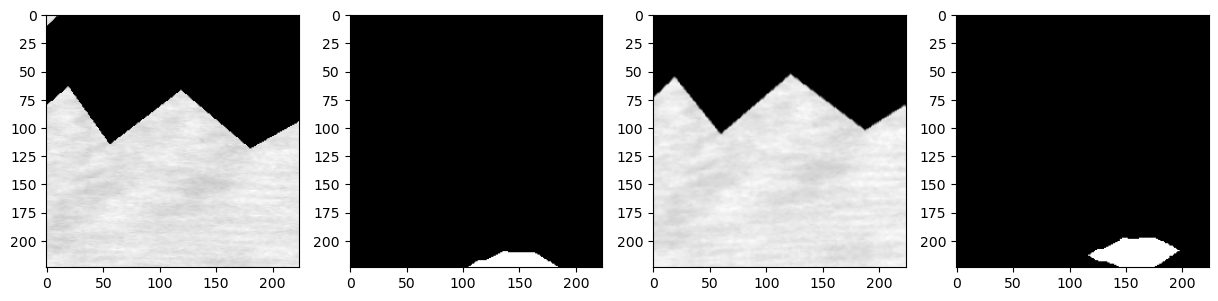

In [22]:

plot_dataset = CustomDataset(
    train_images, CFG, labels=train_masks)

transform = CFG.train_aug_list
transform = A.Compose(
    [t for t in transform if not isinstance(t, (A.Normalize, ToTensorV2))])


plot_count = 0
for i in range(1000):

    image, mask = plot_dataset[i]
    data = transform(image=image, mask=mask)
    aug_image = data['image']
    aug_mask = data['mask']

    if mask.sum() == 0:
        continue

    fig, axes = plt.subplots(1, 4, figsize=(15, 8))
    axes[0].imshow(image[..., 0], cmap="gray")
    axes[1].imshow(mask, cmap="gray")
    axes[2].imshow(aug_image[..., 0], cmap="gray")
    axes[3].imshow(aug_mask, cmap="gray")
    
    plt.savefig(CFG.figures_dir + f'aug_fold_{CFG.valid_id}_{plot_count}.png')

    plot_count += 1
    if plot_count == 5:
        break

In [23]:
del plot_dataset
gc.collect()

48115

## model

In [24]:
class CustomModel(nn.Module):
    def __init__(self, cfg, weight=None):
        super().__init__()
        self.cfg = cfg

        self.encoder = smp.Unet(
            encoder_name=cfg.backbone, 
            encoder_weights=weight,
            in_channels=cfg.in_chans,
            classes=cfg.target_size,
            activation=None,
        )

    def forward(self, image):
        output = self.encoder(image)
        # output = output.squeeze(-1)
        return output


def build_model(cfg, weight="imagenet"):
    print('model_name', cfg.model_name)
    print('backbone', cfg.backbone)

    model = CustomModel(cfg, weight)

    return model

In [25]:
# def build_model():
#     model = smp.Unet(
#         encoder_name=CFG.backbone,      # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
#         encoder_weights=None,     # use `imagenet` pre-trained weights for encoder initialization
#         in_channels=CFG.in_chans,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
#         classes=CFG.target_size,        # model output channels (number of classes in your dataset)
#         activation=None,
#     )
#     model.to(CFG.device)
#     return model

# def load_model(path):
#     model = build_model()
#     model.load_state_dict(torch.load(path))
#     model.eval()
#     return model

## scheduler

In [26]:

import torch.nn as nn
import torch
import math
import time
import numpy as np
import torch

from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau
from warmup_scheduler import GradualWarmupScheduler


class GradualWarmupSchedulerV2(GradualWarmupScheduler):
    """
    https://www.kaggle.com/code/underwearfitting/single-fold-training-of-resnet200d-lb0-965
    """
    def __init__(self, optimizer, multiplier, total_epoch, after_scheduler=None):
        super(GradualWarmupSchedulerV2, self).__init__(
            optimizer, multiplier, total_epoch, after_scheduler)

    def get_lr(self):
        if self.last_epoch > self.total_epoch:
            if self.after_scheduler:
                if not self.finished:
                    self.after_scheduler.base_lrs = [
                        base_lr * self.multiplier for base_lr in self.base_lrs]
                    self.finished = True
                return self.after_scheduler.get_lr()
            return [base_lr * self.multiplier for base_lr in self.base_lrs]
        if self.multiplier == 1.0:
            return [base_lr * (float(self.last_epoch) / self.total_epoch) for base_lr in self.base_lrs]
        else:
            return [base_lr * ((self.multiplier - 1.) * self.last_epoch / self.total_epoch + 1.) for base_lr in self.base_lrs]

def get_scheduler(cfg, optimizer):
    scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer, cfg.epochs, eta_min=1e-7)
    scheduler = GradualWarmupSchedulerV2(
        optimizer, multiplier=10, total_epoch=1, after_scheduler=scheduler_cosine)

    return scheduler

def scheduler_step(scheduler, avg_val_loss, epoch):
    scheduler.step(epoch)


In [27]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [28]:
model = build_model(CFG)
model.to(device)

optimizer = AdamW(model.parameters(), lr=CFG.lr)
scheduler = get_scheduler(CFG, optimizer)

model_name Unet
backbone se_resnext101_32x4d


## loss

In [29]:

DiceLoss = smp.losses.DiceLoss(mode='binary')
BCELoss = smp.losses.SoftBCEWithLogitsLoss()

alpha = 0.5
beta = 1 - alpha
TverskyLoss = smp.losses.TverskyLoss(
    mode='binary', log_loss=False, alpha=alpha, beta=beta)

def criterion(y_pred, y_true):
    # return 0.5 * BCELoss(y_pred, y_true) + 0.5 * DiceLoss(y_pred, y_true)
    return BCELoss(y_pred, y_true)
    # return 0.5 * BCELoss(y_pred, y_true) + 0.5 * TverskyLoss(y_pred, y_true)

## train, val

In [30]:
def train_fn(train_loader, model, criterion, optimizer, device):
    model.train()

    scaler = GradScaler(enabled=CFG.use_amp)
    losses = AverageMeter()

    for step, (images, labels) in tqdm(enumerate(train_loader), total=len(train_loader)):
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)

        with autocast(CFG.use_amp):
            y_preds = model(images)
            loss = criterion(y_preds, labels)

        losses.update(loss.item(), batch_size)
        scaler.scale(loss).backward()

        grad_norm = torch.nn.utils.clip_grad_norm_(
            model.parameters(), CFG.max_grad_norm)

        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()

    return losses.avg

def valid_fn(valid_loader, model, criterion, device, valid_xyxys, valid_mask_gt):
    mask_pred = np.zeros(valid_mask_gt.shape)
    mask_count = np.zeros(valid_mask_gt.shape)

    model.eval()
    losses = AverageMeter()

    for step, (images, labels) in tqdm(enumerate(valid_loader), total=len(valid_loader)):
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)

        with torch.no_grad():
            y_preds = model(images)
            loss = criterion(y_preds, labels)
        losses.update(loss.item(), batch_size)

        # make whole mask
        y_preds = torch.sigmoid(y_preds).to('cpu').numpy()
        start_idx = step*CFG.valid_batch_size
        end_idx = start_idx + batch_size
        for i, (x1, y1, x2, y2) in enumerate(valid_xyxys[start_idx:end_idx]):
            mask_pred[y1:y2, x1:x2] += y_preds[i].squeeze(0)
            mask_count[y1:y2, x1:x2] += np.ones((CFG.tile_size, CFG.tile_size))

    print(f'mask_count_min: {mask_count.min()}')
    mask_pred /= mask_count
    return losses.avg, mask_pred

## metrics

In [31]:
from sklearn.metrics import fbeta_score

def fbeta_numpy(targets, preds, beta=0.5, smooth=1e-5):
    """
    https://www.kaggle.com/competitions/vesuvius-challenge-ink-detection/discussion/397288
    """
    y_true_count = targets.sum()
    ctp = preds[targets==1].sum()
    cfp = preds[targets==0].sum()
    beta_squared = beta * beta

    c_precision = ctp / (ctp + cfp + smooth)
    c_recall = ctp / (y_true_count + smooth)
    dice = (1 + beta_squared) * (c_precision * c_recall) / (beta_squared * c_precision + c_recall + smooth)

    return dice

def calc_fbeta(mask, mask_pred):
    mask = mask.astype(int).flatten()
    mask_pred = mask_pred.flatten()

    best_th = 0
    best_dice = 0
    for th in np.array(range(10, 50+1, 5)) / 100:
        
        # dice = fbeta_score(mask, (mask_pred >= th).astype(int), beta=0.5)
        dice = fbeta_numpy(mask, (mask_pred >= th).astype(int), beta=0.5)
        print(f'th: {th}, fbeta: {dice}')

        if dice > best_dice:
            best_dice = dice
            best_th = th
    
    Logger.info(f'best_th: {best_th}, fbeta: {best_dice}')
    return best_dice, best_th


def calc_cv(mask_gt, mask_pred):
    best_dice, best_th = calc_fbeta(mask_gt, mask_pred)

    return best_dice, best_th

## main

In [32]:
fragment_id = CFG.valid_id

valid_mask_gt = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/inklabels.png", 0)
valid_mask_gt = valid_mask_gt / 255
pad0 = (CFG.tile_size - valid_mask_gt.shape[0] % CFG.tile_size)
pad1 = (CFG.tile_size - valid_mask_gt.shape[1] % CFG.tile_size)
valid_mask_gt = np.pad(valid_mask_gt, [(0, pad0), (0, pad1)], constant_values=0)

In [33]:

fold = CFG.valid_id

if CFG.metric_direction == 'minimize':
    best_score = np.inf
elif CFG.metric_direction == 'maximize':
    best_score = -1

best_loss = np.inf

for epoch in range(CFG.epochs):

    start_time = time.time()

    # train
    avg_loss = train_fn(train_loader, model, criterion, optimizer, device)

    # eval
    avg_val_loss, mask_pred = valid_fn(
        valid_loader, model, criterion, device, valid_xyxys, valid_mask_gt)

    scheduler_step(scheduler, avg_val_loss, epoch)

    best_dice, best_th = calc_cv(valid_mask_gt, mask_pred)

    # score = avg_val_loss
    score = best_dice

    elapsed = time.time() - start_time

    Logger.info(
        f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
    # Logger.info(f'Epoch {epoch+1} - avgScore: {avg_score:.4f}')
    Logger.info(
        f'Epoch {epoch+1} - avgScore: {score:.4f}')

    if CFG.metric_direction == 'minimize':
        update_best = score < best_score
    elif CFG.metric_direction == 'maximize':
        update_best = score > best_score

    if update_best:
        best_loss = avg_val_loss
        best_score = score

        Logger.info(
            f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
        Logger.info(
            f'Epoch {epoch+1} - Save Best Loss: {best_loss:.4f} Model')
        
        torch.save({'model': model.state_dict(),
                    'preds': mask_pred},
                    CFG.model_dir + f'{CFG.model_name}_fold{fold}_best.pth')

  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0


/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:154: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


th: 0.1, fbeta: 0.21195353980198092
th: 0.15, fbeta: 0.23151030791685634
th: 0.2, fbeta: 0.23785156710563382
th: 0.25, fbeta: 0.24362583990338862
th: 0.3, fbeta: 0.2509518625853115
th: 0.35, fbeta: 0.2549832357723729
th: 0.4, fbeta: 0.232188566431868
th: 0.45, fbeta: 0.12857692549573238


best_th: 0.35, fbeta: 0.2549832357723729
Epoch 1 - avg_train_loss: 0.4033  avg_val_loss: 0.3224  time: 222s
Epoch 1 - avgScore: 0.2550
Epoch 1 - Save Best Score: 0.2550 Model
Epoch 1 - Save Best Loss: 0.3224 Model


th: 0.5, fbeta: 0.023066299821154868


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.2341633660451468
th: 0.15, fbeta: 0.24106925709188504
th: 0.2, fbeta: 0.2474803962489805
th: 0.25, fbeta: 0.25559854823398176
th: 0.3, fbeta: 0.26563759003264753
th: 0.35, fbeta: 0.2718769719288474
th: 0.4, fbeta: 0.1921933226148771
th: 0.45, fbeta: 0.028242308860940354


best_th: 0.35, fbeta: 0.2718769719288474
Epoch 2 - avg_train_loss: 0.3180  avg_val_loss: 0.2959  time: 227s
Epoch 2 - avgScore: 0.2719
Epoch 2 - Save Best Score: 0.2719 Model
Epoch 2 - Save Best Loss: 0.2959 Model


th: 0.5, fbeta: 0.0013563446080865373


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0


/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:715: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


th: 0.1, fbeta: 0.23969869063162885
th: 0.15, fbeta: 0.24294302802003148
th: 0.2, fbeta: 0.2648124020134161
th: 0.25, fbeta: 0.2701675555764219
th: 0.3, fbeta: 0.19445938635354756
th: 0.35, fbeta: 0.09323943449937587
th: 0.4, fbeta: 0.020586084171610803
th: 0.45, fbeta: 2.43400079045577e-05


best_th: 0.25, fbeta: 0.2701675555764219
Epoch 3 - avg_train_loss: 0.2863  avg_val_loss: 0.2572  time: 229s
Epoch 3 - avgScore: 0.2702


th: 0.5, fbeta: 0.0


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.24151336281691632
th: 0.15, fbeta: 0.256360002329733
th: 0.2, fbeta: 0.2769188520665362
th: 0.25, fbeta: 0.3075719267296963
th: 0.3, fbeta: 0.3454001151306139
th: 0.35, fbeta: 0.3136076253962449
th: 0.4, fbeta: 0.2339855448017699
th: 0.45, fbeta: 0.04207552331745816


best_th: 0.3, fbeta: 0.3454001151306139
Epoch 4 - avg_train_loss: 0.2733  avg_val_loss: 0.2521  time: 229s
Epoch 4 - avgScore: 0.3454
Epoch 4 - Save Best Score: 0.3454 Model
Epoch 4 - Save Best Loss: 0.2521 Model


th: 0.5, fbeta: 0.0


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.2536593680622922
th: 0.15, fbeta: 0.2738892918504928
th: 0.2, fbeta: 0.29818132885590776
th: 0.25, fbeta: 0.3062725022848258
th: 0.3, fbeta: 0.30466822450536446
th: 0.35, fbeta: 0.29169631531534373
th: 0.4, fbeta: 0.2606488298857086
th: 0.45, fbeta: 0.19698622200721394


best_th: 0.25, fbeta: 0.3062725022848258
Epoch 5 - avg_train_loss: 0.2670  avg_val_loss: 0.2598  time: 228s
Epoch 5 - avgScore: 0.3063


th: 0.5, fbeta: 8.893609609244072e-05


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.2943119905288601
th: 0.15, fbeta: 0.31821030229864317
th: 0.2, fbeta: 0.322377645856884
th: 0.25, fbeta: 0.3183645274240883
th: 0.3, fbeta: 0.3078889601791845
th: 0.35, fbeta: 0.27203824214918626
th: 0.4, fbeta: 0.22993723163980626
th: 0.45, fbeta: 0.17329339857297513


best_th: 0.2, fbeta: 0.322377645856884
Epoch 6 - avg_train_loss: 0.2587  avg_val_loss: 0.2928  time: 230s
Epoch 6 - avgScore: 0.3224


th: 0.5, fbeta: 0.02850199690683281


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.2645285828338556
th: 0.15, fbeta: 0.2788106060757022
th: 0.2, fbeta: 0.2880287185515214
th: 0.25, fbeta: 0.3009274739997416
th: 0.3, fbeta: 0.31419200521157264
th: 0.35, fbeta: 0.3104375971500531
th: 0.4, fbeta: 0.2992422173401062
th: 0.45, fbeta: 0.2823619985612584


best_th: 0.3, fbeta: 0.31419200521157264
Epoch 7 - avg_train_loss: 0.2532  avg_val_loss: 0.2699  time: 227s
Epoch 7 - avgScore: 0.3142


th: 0.5, fbeta: 0.25117357910428617


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.25018248513001656
th: 0.15, fbeta: 0.26654328723287396
th: 0.2, fbeta: 0.2899039724856197
th: 0.25, fbeta: 0.3139606334970954
th: 0.3, fbeta: 0.3288977977480453
th: 0.35, fbeta: 0.3371877525429958
th: 0.4, fbeta: 0.33643608395961616
th: 0.45, fbeta: 0.32601663919048307


best_th: 0.35, fbeta: 0.3371877525429958
Epoch 8 - avg_train_loss: 0.2419  avg_val_loss: 0.2702  time: 228s
Epoch 8 - avgScore: 0.3372


th: 0.5, fbeta: 0.2991417285441475


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.2421375666529511
th: 0.15, fbeta: 0.24782904527656255
th: 0.2, fbeta: 0.2543816678225084
th: 0.25, fbeta: 0.2629496874550098
th: 0.3, fbeta: 0.2707137889782684
th: 0.35, fbeta: 0.27649986827085304
th: 0.4, fbeta: 0.27886552301555456
th: 0.45, fbeta: 0.2814976668637846


best_th: 0.5, fbeta: 0.2844047926518067
Epoch 9 - avg_train_loss: 0.2302  avg_val_loss: 0.3436  time: 228s
Epoch 9 - avgScore: 0.2844


th: 0.5, fbeta: 0.2844047926518067


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.25338942749878607
th: 0.15, fbeta: 0.2628907611379959
th: 0.2, fbeta: 0.2697492224542585
th: 0.25, fbeta: 0.2757992867854223
th: 0.3, fbeta: 0.28162170837279193
th: 0.35, fbeta: 0.29003582164813774
th: 0.4, fbeta: 0.297355096348702
th: 0.45, fbeta: 0.30227860513029586


best_th: 0.5, fbeta: 0.3024067994501148
Epoch 10 - avg_train_loss: 0.2206  avg_val_loss: 0.3043  time: 227s
Epoch 10 - avgScore: 0.3024


th: 0.5, fbeta: 0.3024067994501148


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.24215043284985618
th: 0.15, fbeta: 0.24661128504199137
th: 0.2, fbeta: 0.252954513475341
th: 0.25, fbeta: 0.25820231714496766
th: 0.3, fbeta: 0.26497217521049
th: 0.35, fbeta: 0.27238109982665665
th: 0.4, fbeta: 0.2783667971596202
th: 0.45, fbeta: 0.28831607836728607


best_th: 0.5, fbeta: 0.2979807447475715
Epoch 11 - avg_train_loss: 0.2083  avg_val_loss: 0.3448  time: 230s
Epoch 11 - avgScore: 0.2980


th: 0.5, fbeta: 0.2979807447475715


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.2544532244413223
th: 0.15, fbeta: 0.26298073464682375
th: 0.2, fbeta: 0.2694468911704137
th: 0.25, fbeta: 0.27309310848524365
th: 0.3, fbeta: 0.2777662840831311
th: 0.35, fbeta: 0.28090482460690136
th: 0.4, fbeta: 0.2799887988721081
th: 0.45, fbeta: 0.2761875918442711


best_th: 0.35, fbeta: 0.28090482460690136
Epoch 12 - avg_train_loss: 0.1953  avg_val_loss: 0.3322  time: 229s
Epoch 12 - avgScore: 0.2809


th: 0.5, fbeta: 0.2717242053579779


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.256790302039053
th: 0.15, fbeta: 0.2635976605181926
th: 0.2, fbeta: 0.2698827563881679
th: 0.25, fbeta: 0.27569374953660625
th: 0.3, fbeta: 0.27956369999817576
th: 0.35, fbeta: 0.28238977578231667
th: 0.4, fbeta: 0.2838029823814007
th: 0.45, fbeta: 0.2876190549359099


best_th: 0.5, fbeta: 0.29256235970272804
Epoch 13 - avg_train_loss: 0.1840  avg_val_loss: 0.3407  time: 227s
Epoch 13 - avgScore: 0.2926


th: 0.5, fbeta: 0.29256235970272804


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.2551206490853723
th: 0.15, fbeta: 0.26411059726050157
th: 0.2, fbeta: 0.26782594747911515
th: 0.25, fbeta: 0.26980122483471136
th: 0.3, fbeta: 0.27364344977022204
th: 0.35, fbeta: 0.27956280168392805
th: 0.4, fbeta: 0.2841005197457074
th: 0.45, fbeta: 0.28512559577127705


best_th: 0.5, fbeta: 0.28605842312780555
Epoch 14 - avg_train_loss: 0.1736  avg_val_loss: 0.3557  time: 227s
Epoch 14 - avgScore: 0.2861


th: 0.5, fbeta: 0.28605842312780555


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.2671892552037551
th: 0.15, fbeta: 0.27244341232425506
th: 0.2, fbeta: 0.275338138916816
th: 0.25, fbeta: 0.279280469890351
th: 0.3, fbeta: 0.2830131742534684
th: 0.35, fbeta: 0.2870112182628153
th: 0.4, fbeta: 0.2916593082052841
th: 0.45, fbeta: 0.29441359182026355


best_th: 0.45, fbeta: 0.29441359182026355
Epoch 15 - avg_train_loss: 0.1621  avg_val_loss: 0.3488  time: 229s
Epoch 15 - avgScore: 0.2944


th: 0.5, fbeta: 0.29367887526315684


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.26641610282548506
th: 0.15, fbeta: 0.27358014849942114
th: 0.2, fbeta: 0.27817278431077386
th: 0.25, fbeta: 0.28257153705701205
th: 0.3, fbeta: 0.2825649724219157
th: 0.35, fbeta: 0.2802992891157443
th: 0.4, fbeta: 0.27631787494922944
th: 0.45, fbeta: 0.2721065525084329


best_th: 0.25, fbeta: 0.28257153705701205
Epoch 16 - avg_train_loss: 0.1525  avg_val_loss: 0.3410  time: 229s
Epoch 16 - avgScore: 0.2826


th: 0.5, fbeta: 0.26804361787659164


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.25521962605885495
th: 0.15, fbeta: 0.26395304346307463
th: 0.2, fbeta: 0.2712388336523133
th: 0.25, fbeta: 0.2766077888273729
th: 0.3, fbeta: 0.2809174645283616
th: 0.35, fbeta: 0.2859366140299275
th: 0.4, fbeta: 0.2908160170339332
th: 0.45, fbeta: 0.2928018482015972


best_th: 0.45, fbeta: 0.2928018482015972
Epoch 17 - avg_train_loss: 0.1431  avg_val_loss: 0.3509  time: 229s
Epoch 17 - avgScore: 0.2928


th: 0.5, fbeta: 0.29104066324930605


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.25827034232592344
th: 0.15, fbeta: 0.2641984697054185
th: 0.2, fbeta: 0.26773482617091154
th: 0.25, fbeta: 0.2714965127296608
th: 0.3, fbeta: 0.27356188988533564
th: 0.35, fbeta: 0.270558288077364
th: 0.4, fbeta: 0.2685690188753281
th: 0.45, fbeta: 0.26721856528064364


best_th: 0.3, fbeta: 0.27356188988533564
Epoch 18 - avg_train_loss: 0.1343  avg_val_loss: 0.3546  time: 227s
Epoch 18 - avgScore: 0.2736


th: 0.5, fbeta: 0.26300366737217856


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.26262183941700384
th: 0.15, fbeta: 0.2687921250101016
th: 0.2, fbeta: 0.2740983825064148
th: 0.25, fbeta: 0.27700221411054293
th: 0.3, fbeta: 0.27829548359095047
th: 0.35, fbeta: 0.2794587555857062
th: 0.4, fbeta: 0.280606453941012
th: 0.45, fbeta: 0.2799855024330568


best_th: 0.4, fbeta: 0.280606453941012
Epoch 19 - avg_train_loss: 0.1268  avg_val_loss: 0.3600  time: 227s
Epoch 19 - avgScore: 0.2806


th: 0.5, fbeta: 0.27802154411900587


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.2635980499132908
th: 0.15, fbeta: 0.2694203225696341
th: 0.2, fbeta: 0.27265651415965797
th: 0.25, fbeta: 0.277895056193994
th: 0.3, fbeta: 0.2811789966652035
th: 0.35, fbeta: 0.28195799098530416
th: 0.4, fbeta: 0.28002395918315565
th: 0.45, fbeta: 0.2758881497929448


best_th: 0.35, fbeta: 0.28195799098530416
Epoch 20 - avg_train_loss: 0.1205  avg_val_loss: 0.4010  time: 231s
Epoch 20 - avgScore: 0.2820


th: 0.5, fbeta: 0.2714903276921167


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.2673585314786656
th: 0.15, fbeta: 0.26934031310512935
th: 0.2, fbeta: 0.2736619654880965
th: 0.25, fbeta: 0.2756827648271612
th: 0.3, fbeta: 0.2771926463995635
th: 0.35, fbeta: 0.2778195551197341
th: 0.4, fbeta: 0.27796276813562054
th: 0.45, fbeta: 0.2753520961156341


best_th: 0.4, fbeta: 0.27796276813562054
Epoch 21 - avg_train_loss: 0.1147  avg_val_loss: 0.3899  time: 228s
Epoch 21 - avgScore: 0.2780


th: 0.5, fbeta: 0.26705310596943715


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.26118492989793085
th: 0.15, fbeta: 0.26618782210493364
th: 0.2, fbeta: 0.26758742907959
th: 0.25, fbeta: 0.26829611743237297
th: 0.3, fbeta: 0.2689505847476066
th: 0.35, fbeta: 0.26837020163164166
th: 0.4, fbeta: 0.2666779362233553
th: 0.45, fbeta: 0.2657154692180144


best_th: 0.3, fbeta: 0.2689505847476066
Epoch 22 - avg_train_loss: 0.1081  avg_val_loss: 0.4142  time: 229s
Epoch 22 - avgScore: 0.2690


th: 0.5, fbeta: 0.2608970294748646


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.2640379398483907
th: 0.15, fbeta: 0.26876913363458216
th: 0.2, fbeta: 0.2714829880113017
th: 0.25, fbeta: 0.27269431050910975
th: 0.3, fbeta: 0.2737164346928116
th: 0.35, fbeta: 0.272166418828401
th: 0.4, fbeta: 0.26983527073604024
th: 0.45, fbeta: 0.26504402646356184


best_th: 0.3, fbeta: 0.2737164346928116
Epoch 23 - avg_train_loss: 0.1029  avg_val_loss: 0.4026  time: 229s
Epoch 23 - avgScore: 0.2737


th: 0.5, fbeta: 0.25786545272865435


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.26800639155063694
th: 0.15, fbeta: 0.27287637962576367
th: 0.2, fbeta: 0.2748894764990068
th: 0.25, fbeta: 0.2742058332193299
th: 0.3, fbeta: 0.27354643367647913
th: 0.35, fbeta: 0.2714162544807799
th: 0.4, fbeta: 0.26742453245287934
th: 0.45, fbeta: 0.26170112654864647


best_th: 0.2, fbeta: 0.2748894764990068
Epoch 24 - avg_train_loss: 0.0992  avg_val_loss: 0.4175  time: 227s
Epoch 24 - avgScore: 0.2749


th: 0.5, fbeta: 0.2546798884975029


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.2682656619898567
th: 0.15, fbeta: 0.27454117720445315
th: 0.2, fbeta: 0.27784762978883226
th: 0.25, fbeta: 0.2788178494765498
th: 0.3, fbeta: 0.2791856156638823
th: 0.35, fbeta: 0.2789243323513299
th: 0.4, fbeta: 0.2753177450858132
th: 0.45, fbeta: 0.26779080896785185


best_th: 0.3, fbeta: 0.2791856156638823
Epoch 25 - avg_train_loss: 0.0957  avg_val_loss: 0.4254  time: 228s
Epoch 25 - avgScore: 0.2792


th: 0.5, fbeta: 0.2585651637215508


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.2737363225434059
th: 0.15, fbeta: 0.2785671800239423
th: 0.2, fbeta: 0.283430432554699
th: 0.25, fbeta: 0.28575350214940826
th: 0.3, fbeta: 0.285405566440044
th: 0.35, fbeta: 0.282039188251835
th: 0.4, fbeta: 0.27770518101447744
th: 0.45, fbeta: 0.2715934799180253


best_th: 0.25, fbeta: 0.28575350214940826
Epoch 26 - avg_train_loss: 0.0917  avg_val_loss: 0.4274  time: 229s
Epoch 26 - avgScore: 0.2858


th: 0.5, fbeta: 0.2633312478471213


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.2743577225347704
th: 0.15, fbeta: 0.2796416417194964
th: 0.2, fbeta: 0.2823041566155975
th: 0.25, fbeta: 0.2819888115345187
th: 0.3, fbeta: 0.2805127108478985
th: 0.35, fbeta: 0.27667077131501155
th: 0.4, fbeta: 0.27018645894861976
th: 0.45, fbeta: 0.2635858079597832


best_th: 0.2, fbeta: 0.2823041566155975
Epoch 27 - avg_train_loss: 0.0901  avg_val_loss: 0.4278  time: 228s
Epoch 27 - avgScore: 0.2823


th: 0.5, fbeta: 0.25439870718785934


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.2755751120039676
th: 0.15, fbeta: 0.2809640697389161
th: 0.2, fbeta: 0.2839130607945837
th: 0.25, fbeta: 0.2793777394687387
th: 0.3, fbeta: 0.2746954612536865
th: 0.35, fbeta: 0.2700747295068437
th: 0.4, fbeta: 0.26336806020620035
th: 0.45, fbeta: 0.2575848623788276


best_th: 0.2, fbeta: 0.2839130607945837
Epoch 28 - avg_train_loss: 0.0880  avg_val_loss: 0.4495  time: 227s
Epoch 28 - avgScore: 0.2839


th: 0.5, fbeta: 0.25147555845332564


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.2746108795701408
th: 0.15, fbeta: 0.2789773517458035
th: 0.2, fbeta: 0.2824521342880311
th: 0.25, fbeta: 0.2861865435407945
th: 0.3, fbeta: 0.28626312324353886
th: 0.35, fbeta: 0.2832686952897691
th: 0.4, fbeta: 0.2794268518180966
th: 0.45, fbeta: 0.2734048272526628


best_th: 0.3, fbeta: 0.28626312324353886
Epoch 29 - avg_train_loss: 0.0861  avg_val_loss: 0.4412  time: 228s
Epoch 29 - avgScore: 0.2863


th: 0.5, fbeta: 0.2652549364816461


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.27037257711863644
th: 0.15, fbeta: 0.2747190758944405
th: 0.2, fbeta: 0.2789238636480678
th: 0.25, fbeta: 0.28103416682579424
th: 0.3, fbeta: 0.28177917428823407
th: 0.35, fbeta: 0.2800722850084287
th: 0.4, fbeta: 0.2760557394496318
th: 0.45, fbeta: 0.26961384162777735


best_th: 0.3, fbeta: 0.28177917428823407
Epoch 30 - avg_train_loss: 0.0848  avg_val_loss: 0.4375  time: 229s
Epoch 30 - avgScore: 0.2818


th: 0.5, fbeta: 0.262429922783304


In [34]:
check_point = torch.load(
    CFG.model_dir + f'{CFG.model_name}_fold{fold}_{CFG.inf_weight}.pth', map_location=torch.device('cpu'))

In [35]:
mask_pred = check_point['preds']

In [36]:
best_dice, best_th  = calc_fbeta(valid_mask_gt, mask_pred)

th: 0.1, fbeta: 0.24151336281691632
th: 0.15, fbeta: 0.256360002329733
th: 0.2, fbeta: 0.2769188520665362
th: 0.25, fbeta: 0.3075719267296963
th: 0.3, fbeta: 0.3454001151306139
th: 0.35, fbeta: 0.3136076253962449
th: 0.4, fbeta: 0.2339855448017699
th: 0.45, fbeta: 0.04207552331745816


best_th: 0.3, fbeta: 0.3454001151306139


th: 0.5, fbeta: 0.0


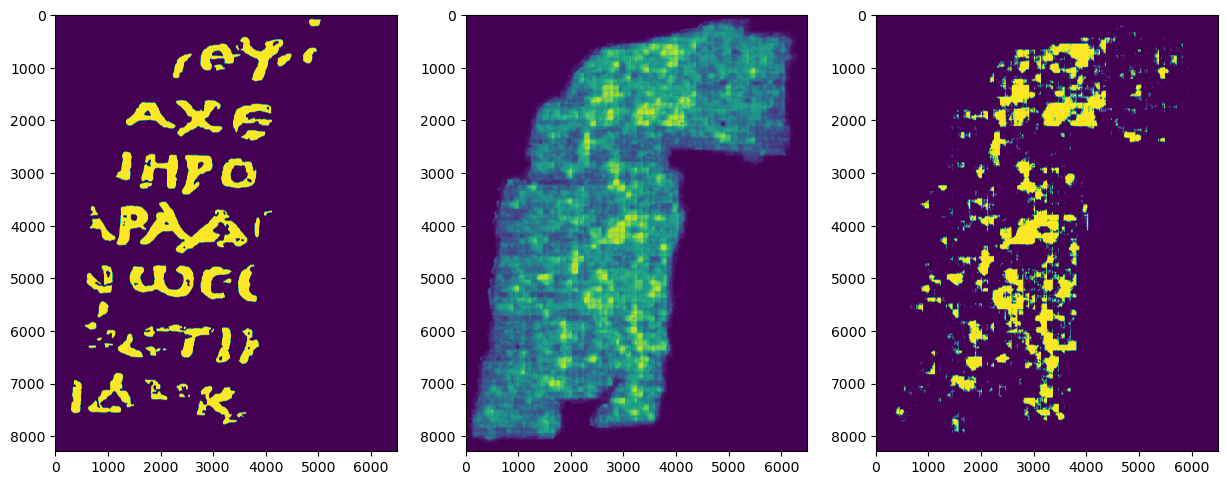

In [37]:
fig, axes = plt.subplots(1, 3, figsize=(15, 8))
axes[0].imshow(valid_mask_gt)
axes[1].imshow(mask_pred)
axes[2].imshow((mask_pred>=best_th).astype(int))

(array([2.5659367e+07, 7.8767700e+05, 5.7788000e+05, 7.2607600e+05,
        1.3371940e+06, 1.9418970e+06, 2.4971500e+06, 2.8299590e+06,
        3.0881050e+06, 3.1848000e+06, 3.3215050e+06, 2.7726690e+06,
        1.6865030e+06, 1.0798960e+06, 7.9131100e+05, 5.5448900e+05,
        4.4096700e+05, 4.0736100e+05, 1.5195400e+05, 2.0880000e+03]),
 array([7.09544665e-05, 2.48673251e-02, 4.96636958e-02, 7.44600664e-02,
        9.92564371e-02, 1.24052808e-01, 1.48849178e-01, 1.73645549e-01,
        1.98441920e-01, 2.23238290e-01, 2.48034661e-01, 2.72831032e-01,
        2.97627402e-01, 3.22423773e-01, 3.47220144e-01, 3.72016514e-01,
        3.96812885e-01, 4.21609256e-01, 4.46405626e-01, 4.71201997e-01,
        4.95998368e-01]),
 <BarContainer object of 20 artists>)

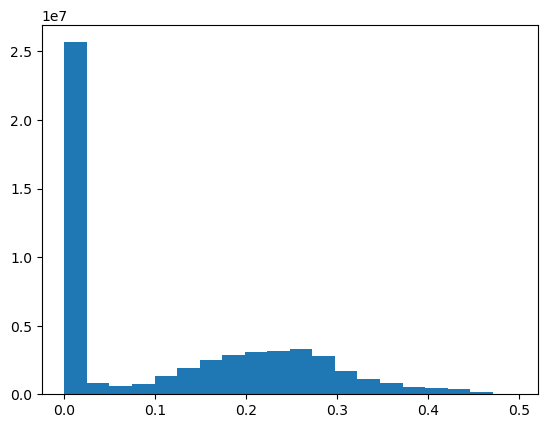

In [38]:
plt.hist(mask_pred.flatten(), bins=20)

In [39]:
# GPU VRAM 5.2GB/16.0GB A4000